# MTL782 Assignment
Team Members:


1.  Khushvind Maurya (2021MT10238)
2.  Aniket Singh (2021MT10256)
3.  Rishabh Jaiswal (2021MT10924)








In [ ]:
!pip install tensorflow tensorflow_decision_forests
!pip install -q -U dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.7 MB/s eta 0:00:00


# Import Libraries

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
import dtreeviz
import random

# Task 1 & 2

## Loading the the provided excel file and converting it into a Pandas dataframe.

In [ ]:
# Before Running, add the required file to the files section of colab
df = pd.read_excel('Data-RF.xlsx')
df.head()

,Lab-Test1(30),Lab-Test2(24),Midsem Test (90),Gender,Attendance,Grade
0,13.00,24,66.0,Male,High,A
1,15.00,24,67.0,Female,High,A
2,5.25,24,45.0,Male,High,B-
3,2.75,19,34.0,Male,High,C-
4,7.25,24,30.0,Male,High,C-


In [ ]:
df.columns = ['Lab_Test_1', 'Lab_Test_2', 'MidSem_Test', 'Gender', 'Attendance', 'Grade']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Lab_Test_1   500 non-null    float64
 1   Lab_Test_2   500 non-null    int64  
 2   MidSem_Test  500 non-null    float64
 3   Gender       500 non-null    object 
 4   Attendance   500 non-null    object 
 5   Grade        500 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 23.6+ KB


As there are 3 categorical attributes, Gender, Attendance, and Grade. We will encode these three.

In [ ]:
classes_gen = df["Gender"].unique().tolist()
print(f"Gender classes: {classes_gen}")

classes_att = df["Attendance"].unique().tolist()
print(f"Attendance classes: {classes_att}")

classes_grd = df["Grade"].unique().tolist()
print(f"Grade classes: {classes_grd}")

Gender classes: ['Male', 'Female', 'Female ', 'Male ']
Attendance classes: ['High', 'Low', 'Moderate']
Grade classes: ['A', 'B-', 'C-', 'D', 'B', 'A-', 'C', 'E']


we see that the unique classes for Gender attributes have repeating values (Because of an space ' '). We correct be before moving forward.

In [ ]:
df["Gender"] = df["Gender"].str.strip()

## Encoding the categorical data.

TF-DF requires classification labels to be integers in [0, num_labels), so we convert the label column 'Grade' from strings to integers.

In [ ]:
classes_grd = df["Grade"].unique().tolist()
print(f"Grade classes: {classes_grd}")
df["Grade"] = df["Grade"].map(classes_grd.index)

Grade classes: ['A', 'B-', 'C-', 'D', 'B', 'A-', 'C', 'E']


In [ ]:
encoded_df = df.copy()

classes_gen = encoded_df["Gender"].unique().tolist()
print(f"Gender classes: {classes_gen}")
encoded_df["Gender"] = encoded_df["Gender"].map(classes_gen.index)

classes_att = encoded_df["Attendance"].unique().tolist()
print(f"Attendance classes: {classes_att}")
encoded_df["Attendance"] = encoded_df["Attendance"].map(classes_att.index)

Gender classes: ['Male', 'Female']
Attendance classes: ['High', 'Low', 'Moderate']


In [ ]:
df.head()

,Lab_Test_1,Lab_Test_2,MidSem_Test,Gender,Attendance,Grade
0,13.00,24,66.0,Male,High,0
1,15.00,24,67.0,Female,High,0
2,5.25,24,45.0,Male,High,1
3,2.75,19,34.0,Male,High,2
4,7.25,24,30.0,Male,High,2


In [ ]:
encoded_df.head()

,Lab_Test_1,Lab_Test_2,MidSem_Test,Gender,Attendance,Grade
0,13.00,24,66.0,0,0,0
1,15.00,24,67.0,1,0,0
2,5.25,24,45.0,0,0,1
3,2.75,19,34.0,0,0,2
4,7.25,24,30.0,0,0,2


## Splitting the datasets


**Note:** To keep the results consistent everytime the notebook is run, we considered the splitting where first 70% data points go to train_df, and remaining 30% go to test_df. We also made a function to perform random splitting incase it is required.

In [ ]:
# Functions To Split Data
def random_split_dataset(dataset, test_ratio=0.30):
  """Randomly splits a panda dataframe in two."""
  indices = df.index.tolist()
  test_size = int(len(df) * test_ratio)

  random.seed(42)
  test_indices = random.sample(population=indices, k=test_size)
  train_indices = [index for index in indices if index not in test_indices]

  train_df = df.loc[train_indices]
  test_df = df.loc[test_indices]
  return train_df, test_df

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two (Not Random)."""
  n_samples = len(dataset)
  split_index = int(n_samples - test_ratio * n_samples)
  train_df = dataset.iloc[:split_index]
  test_df = dataset.iloc[split_index:]
  return train_df, test_df

# Splitting the original df
train_df, test_df = split_dataset(df)
# Splitting the encoded df
enc_train_df, enc_test_df = split_dataset(encoded_df)

In [ ]:
# Converting to Tensorflow datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="Grade")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="Grade")

# Converting to Tensorflow datasets
enc_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(enc_train_df, label="Grade")
enc_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(enc_test_df, label="Grade")

## Taining The Decision Tree Model to compare the accuracies of original dataset, and encoded dataset. (num_trees = 1, for gradient boosted trees is a decision tree)

In [ ]:
model = tfdf.keras.GradientBoostedTreesModel(num_trees = 1, verbose = 0)
model.fit(train_ds)
enc_model = tfdf.keras.GradientBoostedTreesModel(num_trees = 1, verbose = 0)
enc_model.fit(enc_train_ds)

In [ ]:
model.compile(metrics=["accuracy"])
accuracy = model.evaluate(test_ds, return_dict=True, verbose = 0)["accuracy"]
enc_model.compile(metrics=["accuracy"])
enc_accuracy = enc_model.evaluate(enc_test_ds, return_dict=True, verbose = 0)["accuracy"]
print ("Accuracy for a decision tree trained on orignal dataset is, ", accuracy)
print ("Accuracy for a decision tree trained on encoded dataset is, ", enc_accuracy)

Accuracy for a decision tree trained on orignal dataset is,  0.7933333516120911
Accuracy for a decision tree trained on encoded dataset is,  0.7933333516120911


It can be seen that encoding did not have any effect on the accuracy of a decision tree.

## Training Random Forest Model with 30 DTs

In [ ]:
model_rf = tfdf.keras.RandomForestModel(num_trees = 30, verbose = 0)
model_rf.fit(train_ds)

In [ ]:
model_rf.compile(metrics=["accuracy"])
evaluation = model_rf.evaluate(test_ds, return_dict=True, verbose = 0)
accuracy = evaluation["accuracy"]

print ("Accuracy after training random forest model with 30 DTs = ", accuracy)

Accuracy after training random forest model with 30 DTs =  0.8533333539962769


# Task 3


## Visualizing the first tree in the trained in the Random Forest Model


In [ ]:
tfdf.model_plotter.plot_model_in_colab(model_rf,tree_idx=0, max_depth = 10)

In [ ]:
data_features = list(df.columns)
viz_cmodel = dtreeviz.model(model_rf,
                           tree_index=0,
                           X_train=train_df[data_features],
                           y_train=train_df["Grade"],
                           feature_names=data_features,
                           target_name="Grade",
                           class_names=classes_grd)

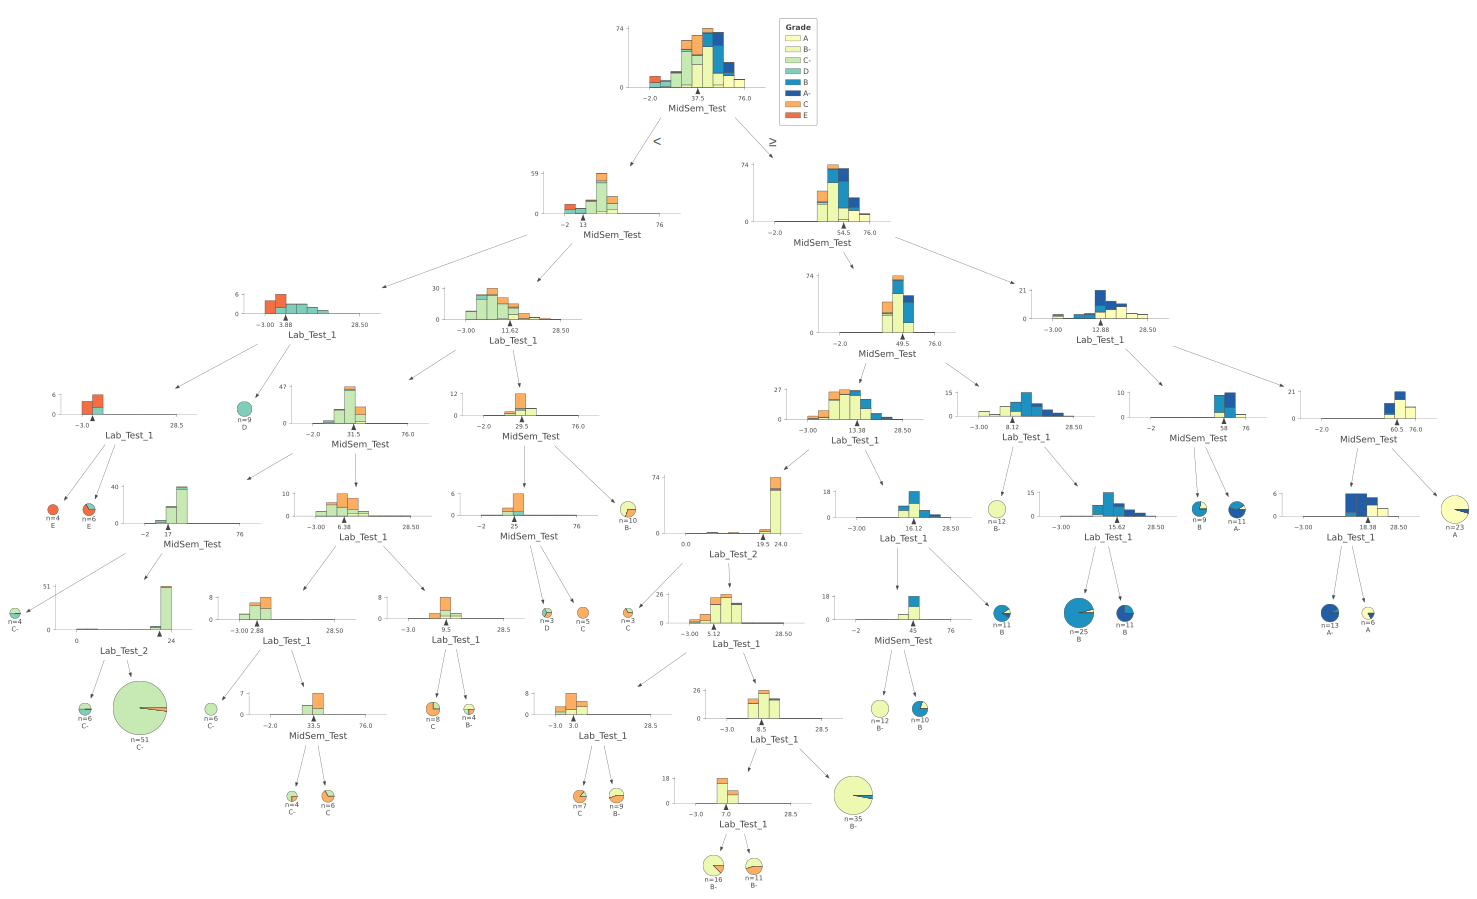

In [ ]:
viz_cmodel.view(scale=1)

# Task 4
**Implementing the Gradient Boosted Decision Trees and comparing their accuracies with the Random Forest implementation having 30 DTs. And plotting accuracy and log loss.**

## Training Gradient Boosted Decision Trees with 30 DTs

In [ ]:
model_gb = tfdf.keras.GradientBoostedTreesModel(num_trees = 30, verbose = 0)
model_gb.fit(train_ds)

In [ ]:
model_gb.compile(metrics=["accuracy"])
accuracy = model_gb.evaluate(test_ds, return_dict=True, verbose = 0)["accuracy"]

print ("Accuracy after training gradient boosted model with 30 DTs, ", accuracy)

Accuracy after training gradient boosted model with 30 DTs,  0.8799999952316284


In [ ]:
tfdf.model_plotter.plot_model_in_colab(model_gb,tree_idx=0)

## Comparing Accuracies Of Random Forest and Gradient Boosted Trees

In [ ]:
model_rf = tfdf.keras.RandomForestModel(num_trees = 30, verbose = 0)
model_gb = tfdf.keras.GradientBoostedTreesModel(num_trees = 30, verbose = 0)

# Train the model.
model_rf.fit(train_ds)
model_gb.fit(train_ds)

In [ ]:
model_rf.compile(metrics=["accuracy"])
accuracy_rf = model_rf.evaluate(test_ds, return_dict=True, verbose = 0)["accuracy"]
model_gb.compile(metrics=["accuracy"])
accuracy_gb = model_gb.evaluate(test_ds, return_dict=True, verbose = 0)["accuracy"]

print ("Accuracy of Random Forest Model is ", accuracy_rf)
print ("Accuracy of Gradient Boosted Tree Model is ", accuracy_gb)

Accuracy of Random Forest Model is  0.8533333539962769
Accuracy of Gradient Boosted Tree Model is  0.8799999952316284


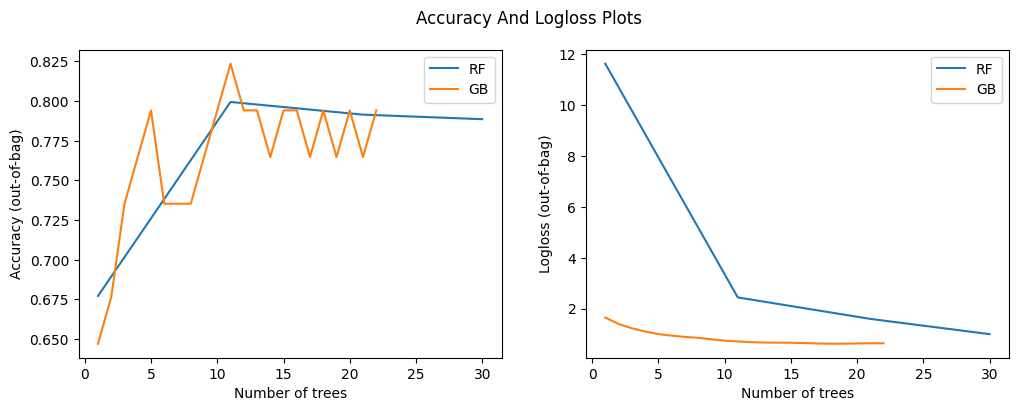

In [ ]:
logs_rf = model_rf.make_inspector().training_logs()
logs_gb = model_gb.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs_rf], [log.evaluation.accuracy for log in logs_rf], label = 'RF')
plt.plot([log.num_trees for log in logs_gb], [log.evaluation.accuracy for log in logs_gb], label = 'GB')
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs_rf], [log.evaluation.loss for log in logs_rf], label = 'RF')
plt.plot([log.num_trees for log in logs_gb], [log.evaluation.loss for log in logs_gb], label = 'GB')
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")
plt.legend()
plt.suptitle('Accuracy And Logloss Plots')

plt.show()

# Task 5


## Comparing the training and testing accuracies of Random Forest Model

In [ ]:
model = tfdf.keras.RandomForestModel(num_trees = 30, verbose = 0)

# Train the model.
model.fit(train_ds)

In [ ]:
model.compile(metrics=["accuracy"])
accuracy_train = model.evaluate(train_ds, return_dict=True, verbose = 0)["accuracy"]
model.compile(metrics=["accuracy"])
accuracy_test = model.evaluate(test_ds, return_dict=True, verbose = 0)["accuracy"]

print ("Training Accuracy is ", accuracy_train)
print ("Testing Accuracy is ", accuracy_test)

Training Accuracy is  0.9285714030265808
Testing Accuracy is  0.8533333539962769


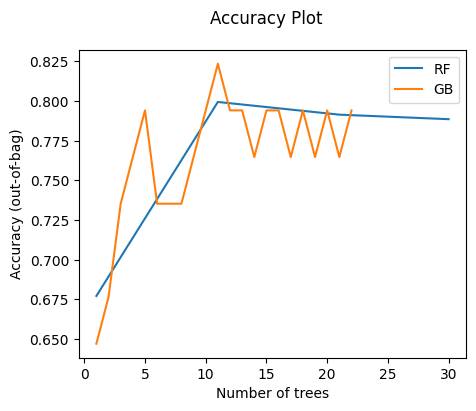

In [ ]:
logs_rf = model_rf.make_inspector().training_logs()
logs_gb = model_gb.make_inspector().training_logs()

plt.figure(figsize=(5, 4))

plt.plot([log.num_trees for log in logs_rf], [log.evaluation.accuracy for log in logs_rf], label = 'RF')
plt.plot([log.num_trees for log in logs_gb], [log.evaluation.accuracy for log in logs_gb], label = 'GB')
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.legend()

plt.suptitle('Accuracy Plot')

plt.show()

## Finding out the number of trees and maximum depth hyper-parameters for a reasonable accuracy of 85%. And finding out the impact of n-trees and max depth hyper-parameter on the performance of model.

In [ ]:
def get_accuracy_rf(train_ds, test_ds, n = 30, md = 6):
  model = tfdf.keras.RandomForestModel(num_trees = n, max_depth = md, verbose = 0)
  model.fit(train_ds)
  model.compile(metrics = ["accuracy"])
  evaluation = model.evaluate(test_ds, return_dict = True,verbose = 0)
  return evaluation["accuracy"]

In [ ]:
num_trees_arr = [i for i in range(2,51,2)]
max_depth_arr = [j for j in range(1,11,1)]
accuracy = np.random.rand(len(num_trees_arr), len(max_depth_arr))

for i in range(len(num_trees_arr)):
  for j in range(len(max_depth_arr)):
    accuracy[i][j] = get_accuracy_rf(train_ds,test_ds,num_trees_arr[i],max_depth_arr[j])

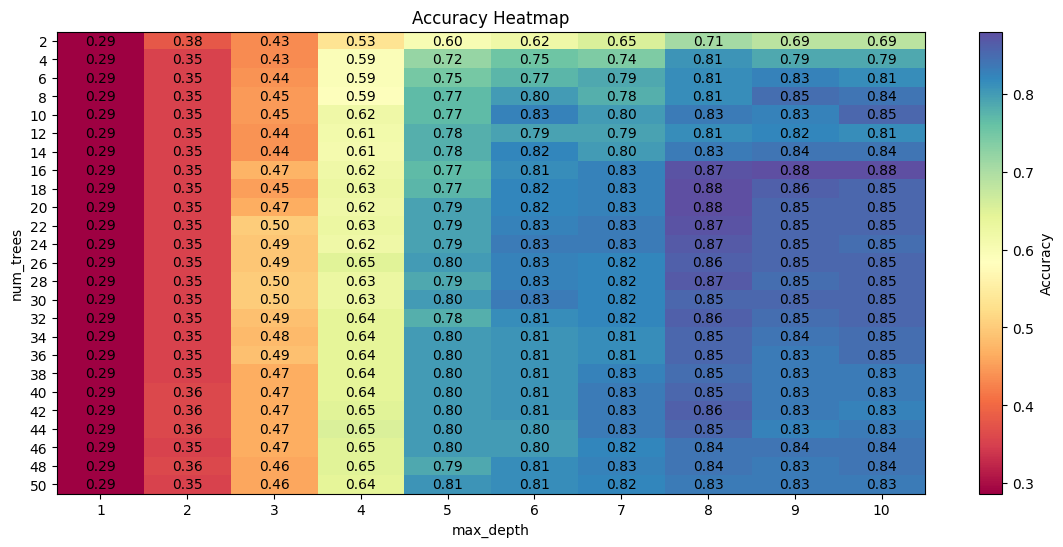

In [ ]:
plt.figure(figsize=(14, 6))
plt.imshow(accuracy, cmap="Spectral", aspect="auto")

# Customize axes
plt.xticks(np.arange(len(max_depth_arr)), max_depth_arr)
plt.yticks(np.arange(len(num_trees_arr)), num_trees_arr)
plt.xlabel("max_depth")
plt.ylabel("num_trees")
plt.title("Accuracy Heatmap")

# Add colorbar
cbar = plt.colorbar(label="Accuracy")
for i in range(len(num_trees_arr)):
    for j in range(len(max_depth_arr)):
        plt.text(j, i, f"{accuracy[i, j]:.2f}", ha="center", va="center", color="black")

plt.show()

From the above plot, we get accuracy of more than or equal to 85% for (num_trees, max_depth) value pairs of (16,8),(16,9),(18,8),(20,8) etc. There are obviously more (num_trees, max_depth) pairs with greater than 85% accuracy that are not shown in the plot.

We can also observe from the heatmap plot of accurcy that on increasing the 'num_trees' (number of trees) hyperparameter the accuracy increases, until it reaches a maximun, after which it decreases slightly, and then remains almost constant. A similar trend in observed with the 'max_depth' hyperparameter. On increasing the 'max_depth' hyperparameter, the accuracy increases to a maximum, after which slighly decreases. It will remain same after a value of 'max_depth' because there is an upper limit to the depth of trees, (because of constant number of attributes).